In [1]:
# %cd notebooks

In [2]:
import matplotlib.backends
import torch
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import cartopy.crs as ccrs 
import matplotlib 
from tqdm.notebook import tqdm
from models.model import Wang2024
from models.data import load_output_data, load_input_data, get_rain_bool, xarray_to_dataloaders
from models.training import train_loop, eval_loop, evaluate_model

from captum.attr import Occlusion, IntegratedGradients


plt.style.use('robin')


In [3]:
%matplotlib inline

In [18]:

ds_ml= xr.open_dataset('/Data/gfi/users/rogui7909/era5_rain_norge/DL_era5_rain_regression_in_out.nc').sel(mask_id=[14]).sel(time=slice(None,'2021'))
# ds_ml['data_in'] = ds_ml.data_in.sel(var_name=['z500'])

ds_ml = ds_ml.where(ds_ml.data_in.count(['longitude', 'latitude']).sum('var_name')==24576, drop=True)
ds_ml['data_out'] = (ds_ml.data_out.rank('time', pct=True)//.1).astype(int)
time = ds_ml.time 

In [19]:
device ='cpu'
model = Wang2024(num_classes=10, num_channels_in=3, image_size=128*64, groups=3).to(device)
model.load_state_dict(torch.load('trained_models/wang2024_ERA5_norwaeyW_precip_10quantiles.torch', weights_only=True))
model.eval()

Wang2024(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=24576, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=10, bias=True)
)

In [20]:

model.eval()
with torch.no_grad():
    model = model.cpu()
    data_in = ds_ml.data_in.values
    X = torch.tensor(data_in).type(torch.float32)
    pred = torch.softmax(model(X), dim=1).detach().numpy()

    pred_ds = xr.DataArray(pred, dims = ['time','quantile'], coords=dict(time=ds_ml.time, quantile=np.arange(0,10)))
    ds_eval = xr.Dataset(dict(truth=ds_ml.data_out.squeeze(), pred_proba=pred_ds, pred=pred_ds.idxmax('quantile'))).sortby('time')


# ds_eval_destandard = ds_eval*ds_ml_std + ds_ml_mean
# ds_eval_destandard = np.exp(ds_eval) + 1e-5
ds_eval.truth.isel(time=slice(0,100)).plot()
ds_eval.pred.isel(time=slice(0,100)).plot()
plt.show()


<Axes: xlabel='pred', ylabel='truth'>

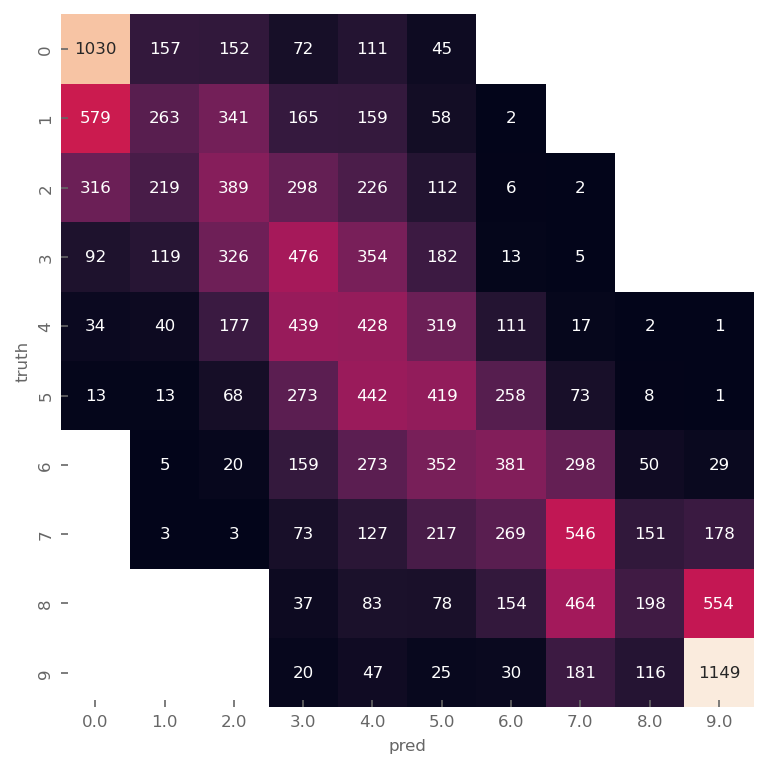

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
df_ = ds_eval[['truth','pred']].to_dataframe()

sns.heatmap(df_.groupby(['truth','pred']).count().unstack().mask_id,
            square=True, cbar=False, annot=True, fmt = '.0f', ax=ax
    )

# XAI

In [22]:
from captum.attr import LRP,DeepLiftShap, Occlusion,IntegratedGradients,NoiseTunnel, DeepLift, Saliency

lrp = LRP(model.to('cpu'))
dlShap =  DeepLiftShap(model.to('cpu'))
dl =  DeepLift(model.to('cpu'))
ig = IntegratedGradients(model.to('cpu'))
ig_noinput = IntegratedGradients(model.to('cpu'),multiply_by_inputs=False)
nt = NoiseTunnel(ig)
nt_noinput = NoiseTunnel(ig_noinput)
sal = Saliency(model)
occ = Occlusion(model.to('cpu'))

In [23]:
ds_over90 = ds_ml.sel(time = df_.query("pred==9&truth==9").index.get_level_values(0)) # 30 is approx 99 percentile
ds_below10 = ds_ml.sel(time = df_.query("pred==0&truth==0").index.get_level_values(0)) # 30 is approx 99 percentile

ds_valid = ds_ml.sel(time = df_.query("pred==truth").index.get_level_values(0)) # 30 is approx 99 percentile
ds_valid_winter = ds_valid.where(ds_valid.time.dt.season=='DJF', drop=True)

In [24]:
input_tensor[i]

tensor([[[-0.7244, -1.3499, -1.4449,  ...,  0.9187, -0.2394, -0.7244],
         [-0.7804, -1.0830, -1.3144,  ...,  0.8224, -0.2988, -0.7804],
         [-0.6736, -0.9745, -1.3007,  ...,  0.3745, -0.1933, -0.6736],
         ...,
         [-1.2269, -1.2027, -1.1827,  ..., -1.2840, -1.2539, -1.2269],
         [-2.4120, -2.3616, -2.3103,  ..., -2.5103, -2.4616, -2.4120],
         [-0.2266, -0.2266, -0.2266,  ..., -0.2266, -0.2266, -0.2266]],

        [[-1.0128, -0.2585, -0.2249,  ..., -1.0882, -1.2956, -1.0128],
         [-0.6448, -0.0112,  0.0765,  ..., -0.7338, -0.8453, -0.6448],
         [-0.3766,  0.2208,  0.4445,  ..., -0.2639, -0.4339, -0.3766],
         ...,
         [ 1.4107,  1.4545,  1.4967,  ...,  1.3275,  1.3682,  1.4107],
         [ 1.6447,  1.7541,  1.8607,  ...,  1.4159,  1.5319,  1.6447],
         [-3.1968, -3.1968, -3.1968,  ..., -3.1968, -3.1968, -3.1968]],

        [[ 0.9122,  0.9120,  0.9115,  ...,  0.8987,  0.9052,  0.9122],
         [ 0.9107,  0.9118,  0.9112,  ...,  0

In [29]:
input_ds = ds_valid_winter
input_tensor = torch.Tensor(input_ds.data_in.values).to('cpu')
targets = torch.Tensor(input_ds.data_out.values.squeeze().astype(int)).type(torch.long)
baseline = torch.Tensor(input_ds.data_in.mean('time').values).reshape(1,3,64,128)
all_attr = []
with torch.no_grad():
    for i in tqdm(range(input_tensor.shape[0])):
        # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline, target=targets[i]).detach().numpy()
        attr_ig_target0 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=0).detach().numpy()
        # attr_ig_target4 = ig.attribute(input_tensor[i], baselines=baseline, target=4).detach().numpy()
        attr_ig_target9 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=9).detach().numpy()
        all_attr.append(np.concatenate([attr_ig_target0,attr_ig_target9]))

ds_attrs_quant_valid = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
            dims=['target','time','var_name','latitude','longitude'], 
            coords= dict(time=input_ds.time,
                        longitude=input_ds.longitude, 
                        latitude=input_ds.latitude,
                        var_name=input_ds.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                        target=[0,9]))
ig_noinput

  0%|          | 0/1415 [00:00<?, ?it/s]

In [30]:
ds_mean_winter_attrs = ds_attrs_quant_valid.squeeze().groupby(ds_valid_winter.squeeze().data_out).mean('time')
ds_mean_winter = ds_valid_winter.data_in.squeeze().groupby(ds_valid_winter.squeeze().data_out).mean('time')

In [38]:
ds_mean_winter_attrs

<xarray.DataArray (target: 2, data_out: 10, var_name: 3, latitude: 64,
                   longitude: 128)> Size: 4MB
array([[[[[-1.40536765e-04,  2.90411362e-04,  8.11303135e-04, ...,
            4.86207240e-04,  9.54956988e-05, -4.47192539e-04],
          [ 1.04653880e-04,  6.28486155e-04,  1.34479631e-03, ...,
           -2.43035345e-03, -1.14254246e-03, -1.05384738e-03],
          [-2.41070490e-05,  4.95353219e-04,  4.80933354e-04, ...,
           -1.18412797e-03, -1.34891105e-03, -7.47329509e-04],
          ...,
          [ 8.41665554e-05, -8.36179251e-04, -7.09374251e-04, ...,
           -5.06390178e-05, -1.94894187e-04, -1.99298937e-04],
          [-7.21032746e-04, -1.75537937e-03, -1.59648936e-03, ...,
           -5.69677834e-04, -4.76401970e-04, -2.07302187e-04],
          [-4.21966387e-04,  1.04866631e-03, -1.22194601e-04, ...,
            6.70790879e-05,  3.02630519e-04,  1.83840318e-04]],

         [[ 2.46163967e-04,  3.01179853e-04,  1.53268272e-04, ...,
           -1.44578792e-04,  7.83765630e-06, -1.73404858e-04],
          [ 1.33915098e-04,  2.38044973e-04,  1.91232380e-04, ...,
            1.65184036e-04,  1.59571994e-04, -9.21587069e-05],
          [ 3.10995232e-04,  1.44464624e-04,  2.93072086e-04, ...,
           -2.63945529e-04, -3.72807548e-04, -2.48650326e-04],
...
          [ 8.38078241e-04,  1.53358773e-03, -2.65876012e-04, ...,
            1.05715286e-03,  1.62738304e-03,  8.63270848e-04],
          [ 1.03584868e-03,  7.65200918e-04, -2.29438101e-03, ...,
            2.97068569e-04,  1.36070837e-03,  7.36206909e-04],
          [ 1.54236615e-03,  5.39707882e-04, -4.41034876e-04, ...,
           -4.87750407e-04, -3.50599786e-04, -3.54673558e-04]],

         [[ 1.22485566e-05,  3.12002821e-05,  1.22059513e-05, ...,
            4.73404306e-05,  1.51294316e-05,  1.52957815e-05],
          [ 1.96016603e-05,  3.86679001e-05,  2.88559861e-05, ...,
            6.27924192e-05,  1.92436279e-05,  1.77187270e-05],
          [ 8.95490106e-06,  1.30803925e-05, -2.28941201e-05, ...,
           -6.18146171e-06,  2.12618156e-05,  2.10076620e-06],
          ...,
          [-6.34543157e-05, -1.04175114e-04, -2.48415354e-05, ...,
           -8.99060671e-05,  2.38970618e-05,  3.03776873e-06],
          [ 6.93428849e-05, -2.39324968e-04, -2.30022098e-04, ...,
           -3.40978830e-04, -2.18198260e-04, -1.57198698e-04],
          [ 2.32290050e-04,  9.06270136e-05,  2.29464184e-04, ...,
            1.55450551e-05,  5.34915247e-05, -4.70856173e-05]]]]])
Coordinates:
  * longitude  (longitude) float64 1kB -180.0 -177.2 -174.3 ... 177.2 180.0
  * latitude   (latitude) float64 512B 0.0 1.429 2.857 ... 87.14 88.57 90.0
  * var_name   (var_name) <U4 48B 'u850' 'v850' 'z500'
  * target     (target) int64 16B 0 9
    mask_id    float64 8B 14.0
    number     int64 8B 0
  * data_out   (data_out) float64 80B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0

In [71]:
cols = [0,2,5,7,9]

plot = ds_mean_winter_attrs.sel(target=0).rolling(longitude=5, latitude=5, center=True).mean().sel(data_out=cols).plot.contourf(
                                                                         subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                                                         col ='data_out', row='var_name',
                                                                         transform=ccrs.PlateCarree(), levels=np.arange(-0.2,0.21,.02), vmax=.5,extend='both', cmap='PuOr_r',
                                                                         size=3, aspect=0.9,
                                                                         cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))

for k in range(len(cols)):
    ds_mean_winter.isel(data_out=cols[k]).coarsen(longitude=3, latitude=3, boundary='pad').mean().to_dataset('var_name').plot.quiver(x='longitude',y='latitude', u='u850', v='v850', ax=plot.axs[0,k], transform=ccrs.PlateCarree())
    ds_mean_winter.isel(data_out=cols[k]).coarsen(longitude=3, latitude=3, boundary='pad').mean().to_dataset('var_name').plot.quiver(x='longitude',y='latitude', u='u850', v='v850', ax=plot.axs[1,k], transform=ccrs.PlateCarree())
    ds_mean_winter.sel(data_out=cols[k], var_name='z500').squeeze().plot.contour(levels=np.arange(-2,2.1,.2),transform=ccrs.PlateCarree(), alpha=.7, ax=plot.axs[2,k])
    for i in range(3):
        plot.axs[i,k].coastlines()
        plot.axs[i,k].set_extent((-60,40, 10,90))
        plot.axs[i,k].set_title(f"True P quantiles {cols[k]*10} to {(cols[k]+1)*10}")
    

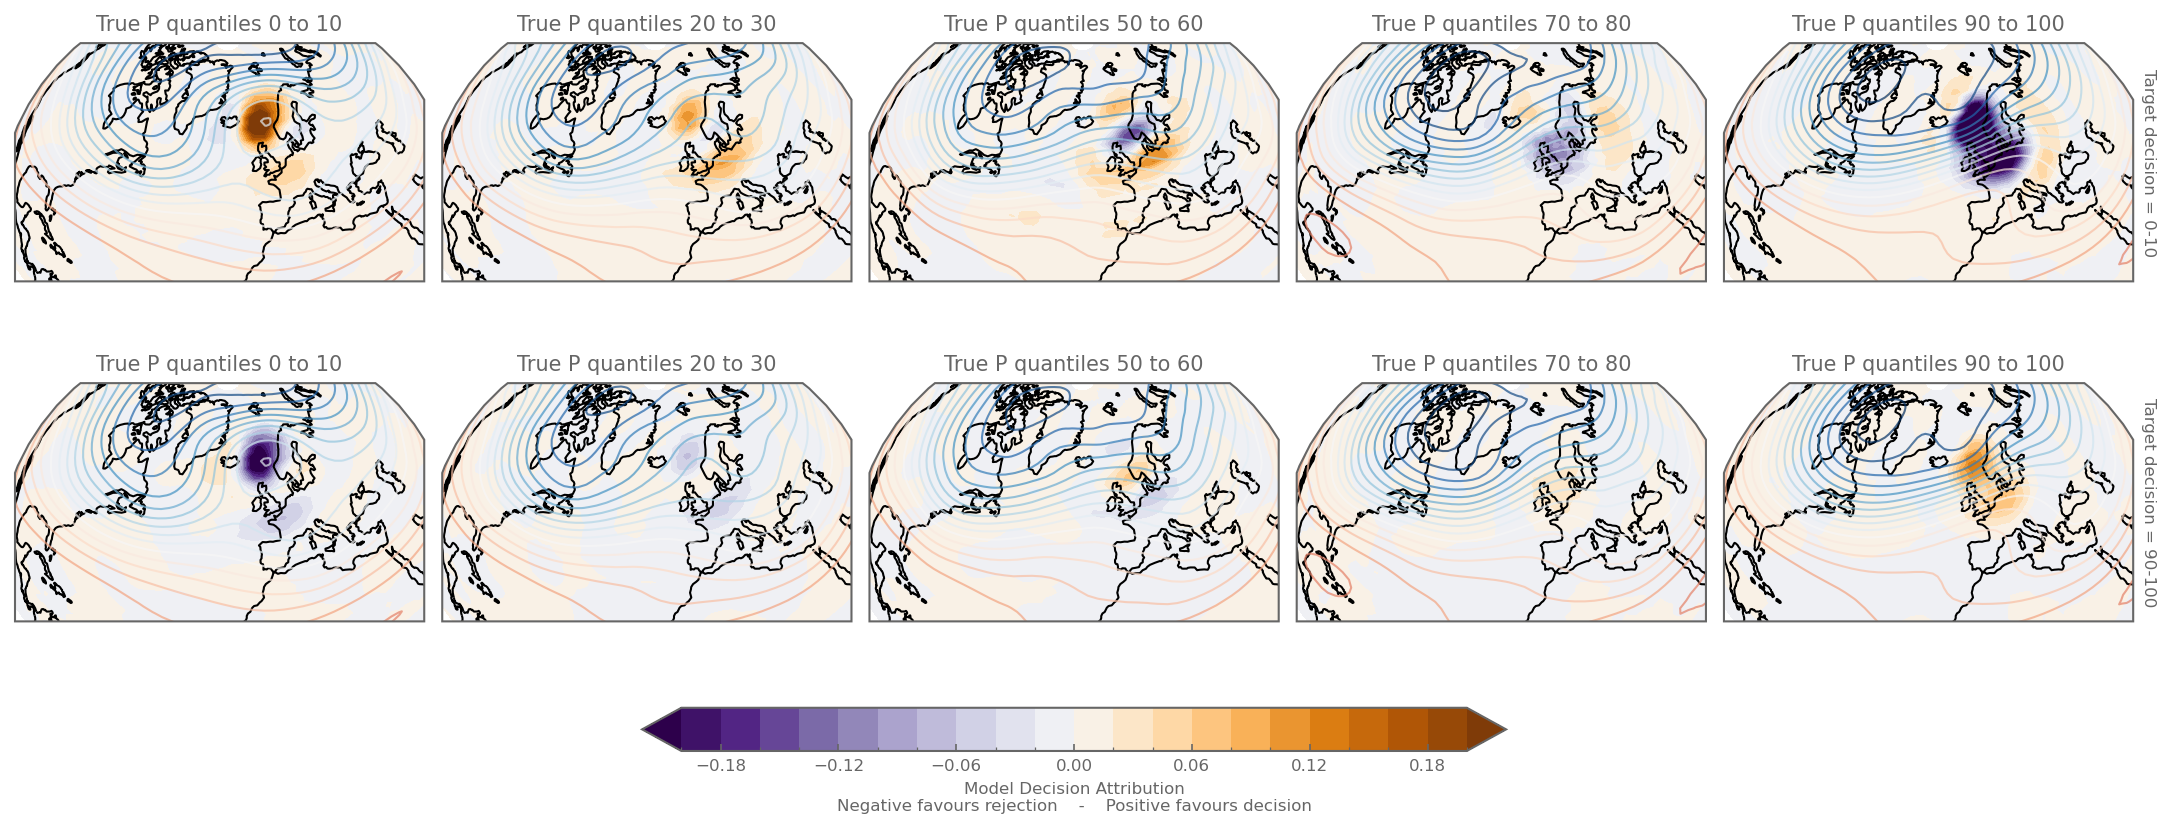

In [ ]:
plot = ds_mean_winter_attrs.assign_coords(target=['0-10','90-100']).rename(target = 'Target decision').rolling(longitude=5, latitude=5, center=True).mean().sel(data_out=col).plot.contourf(
                                                                         subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                                                         col ='data_out', row='Target decision',
                                                                         transform=ccrs.PlateCarree(), levels=np.arange(-0.2,0.21,.02), vmax=.5,extend='both', cmap='PuOr_r',
                                                                         size=3, aspect=0.9,
                                                                         cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))

for k,ax in enumerate(plot.axs.flatten()):
    row = k//5
    col = k%5
    ds_mean_winter.sel(data_out=cols[col]).plot.contour(ax=ax,levels=np.arange(-2,2.1,.2),
                                            transform=ccrs.PlateCarree(), alpha=.7)
        # mean_attrs = ds_mean_winter_attrs.isel(data_out=k).rolling(longitude=5, latitude=5, center=True).mean()
        # mean_attrs = mean_attrs.where(np.abs(mean_attrs)>0.1)
        # mean_attrs.plot.contourf(transform=ccrs.PlateCarree(),ax=ax, levels=10, vmax=.4, vmin=-.4, add_colorbar=False, cmap='RdBu_r')
    ax.coastlines()
    ax.set_extent((-90,40, 10,90))
    if row==4:
        ax.set_ylabel('coucou')
    
    ax.set_title(f"True P quantiles {cols[col]*10} to {(cols[col]+1)*10}")

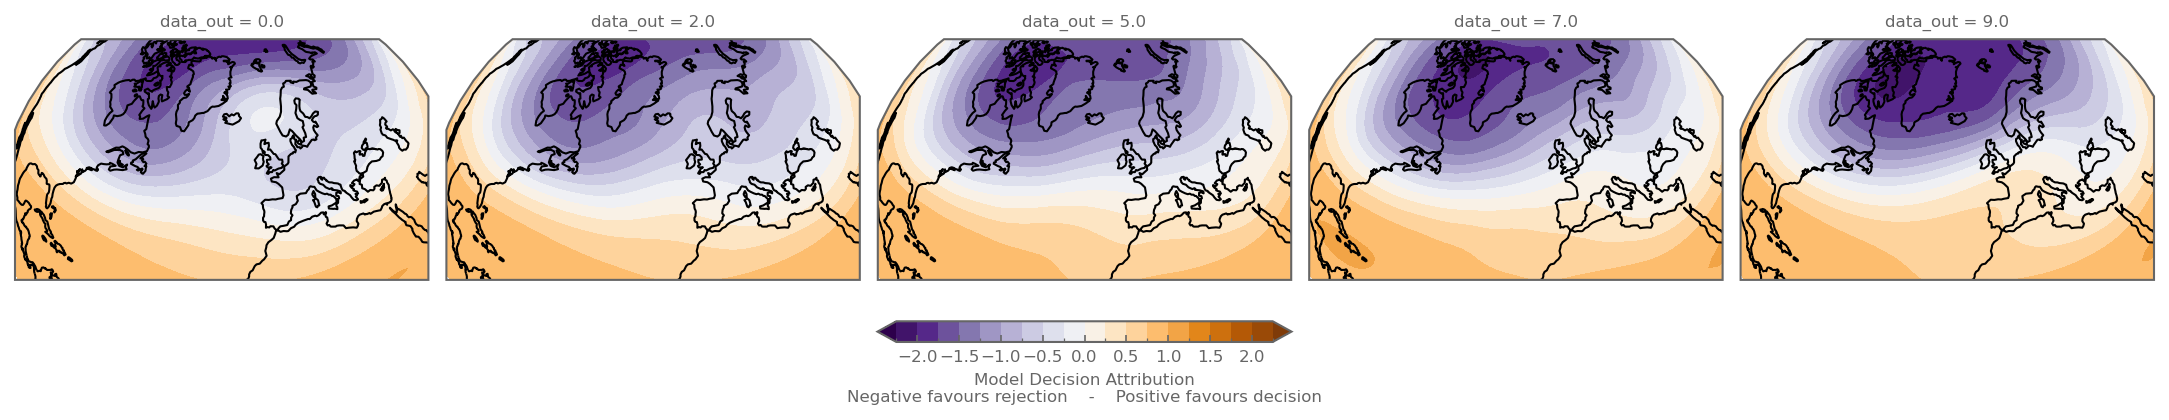

In [281]:
plot = ds_mean_winter.sel(data_out=cols).plot.contourf(subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                    col ='data_out',col_wrap=5,
                                    transform=ccrs.PlateCarree(), levels=20, extend='both', cmap='PuOr_r',
                                    size=3, aspect=0.9,
                                    cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))
for k,ax in enumerate(plot.axs.flatten()):
    ax.coastlines()
    ax.set_extent((-90,40, 10,90))



In [13]:

ds_bad90 = ds_ml.sel(time = df_.query("pred==2&truth==9").index.get_level_values(0)) # 30 is approx 99 percentile
ds_bad90_winter = ds_bad90.where(ds_bad90.time.dt.season=='DJF', drop=True)

In [14]:
input_ds = ds_bad90_winter
input_tensor = torch.Tensor(input_ds.data_in.values).to('cpu')
targets = torch.Tensor(input_ds.data_out.values.squeeze().astype(int)).type(torch.long)
baseline = torch.Tensor(ds_ml.data_in.mean('time').values)
all_attr = []
with torch.no_grad():

    for i in tqdm(range(input_tensor.shape[0])):
        # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline, target=targets[i]).detach().numpy()
        attr_ig_target2 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=2).detach().numpy()
        # attr_ig_target4 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=4).detach().numpy()
        attr_ig_target9 = ig.attribute(input_tensor[i:i+1], baselines=baseline, target=9).detach().numpy()
        all_attr.append(np.concatenate([attr_ig_target2,attr_ig_target9]))

ds_attrs_quant_bad90 = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
            dims=['target','time','var_name','latitude','longitude'], 
            coords= dict(time=input_ds.time,
                        longitude=input_ds.longitude, 
                        latitude=input_ds.latitude,
                        var_name=input_ds.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                        target=[2,9]))

  0%|          | 0/13 [00:00<?, ?it/s]

In [42]:
with torch.no_grad():
    print(np.argmax(model(input_tensor).detach().numpy(), axis=1))


[9 9 2 9 9 9 9 2 9 9 5 9 9]


In [43]:
ds_mean_winter_attrs_bad90 = ds_attrs_quant_valid.mean('time')
ds_mean_winter_bad90 = ds_bad90_winter.mean('time')

In [44]:
plot = ds_mean_winter_attrs_bad90.squeeze().assign_coords(target=['20-30','90-100']).rename(target = 'Target decision').rolling(longitude=5, latitude=5, center=True).mean().plot.contourf(
                                                                         subplot_kws = dict(projection=ccrs.Orthographic(-20,40)),
                                                                        col='Target decision',
                                                                         transform=ccrs.PlateCarree(), levels=np.arange(-0.3,0.31,.02), vmax=.5,extend='both', cmap='PuOr_r',
                                                                         size=3, aspect=0.9,
                                                                         cbar_kwargs = dict(orientation='horizontal', fraction=0.05, shrink=.6, pad=0.1, label='Model Decision Attribution\nNegative favours rejection    -    Positive favours decision'))
for k,ax in enumerate(plot.axs.flatten()):
    title = ax.get_title()
    ds_mean_winter_bad90.data_in.squeeze().plot.contour(ax=ax,levels=np.arange(-2,2.1,.2),
                                            transform=ccrs.PlateCarree(), alpha=.7)
    ax.set_title(title)
        # mean_attrs = ds_mean_winter_attrs.isel(data_out=k).rolling(longitude=5, latitude=5, center=True).mean()
        # mean_attrs = mean_attrs.where(np.abs(mean_attrs)>0.1)
        # mean_attrs.plot.contourf(transform=ccrs.PlateCarree(),ax=ax, levels=10, vmax=.4, vmin=-.4, add_colorbar=False, cmap='RdBu_r')
    ax.coastlines()
    ax.set_extent((-90,40, 10,90))
    if row==4:
        ax.set_ylabel('coucou')
    


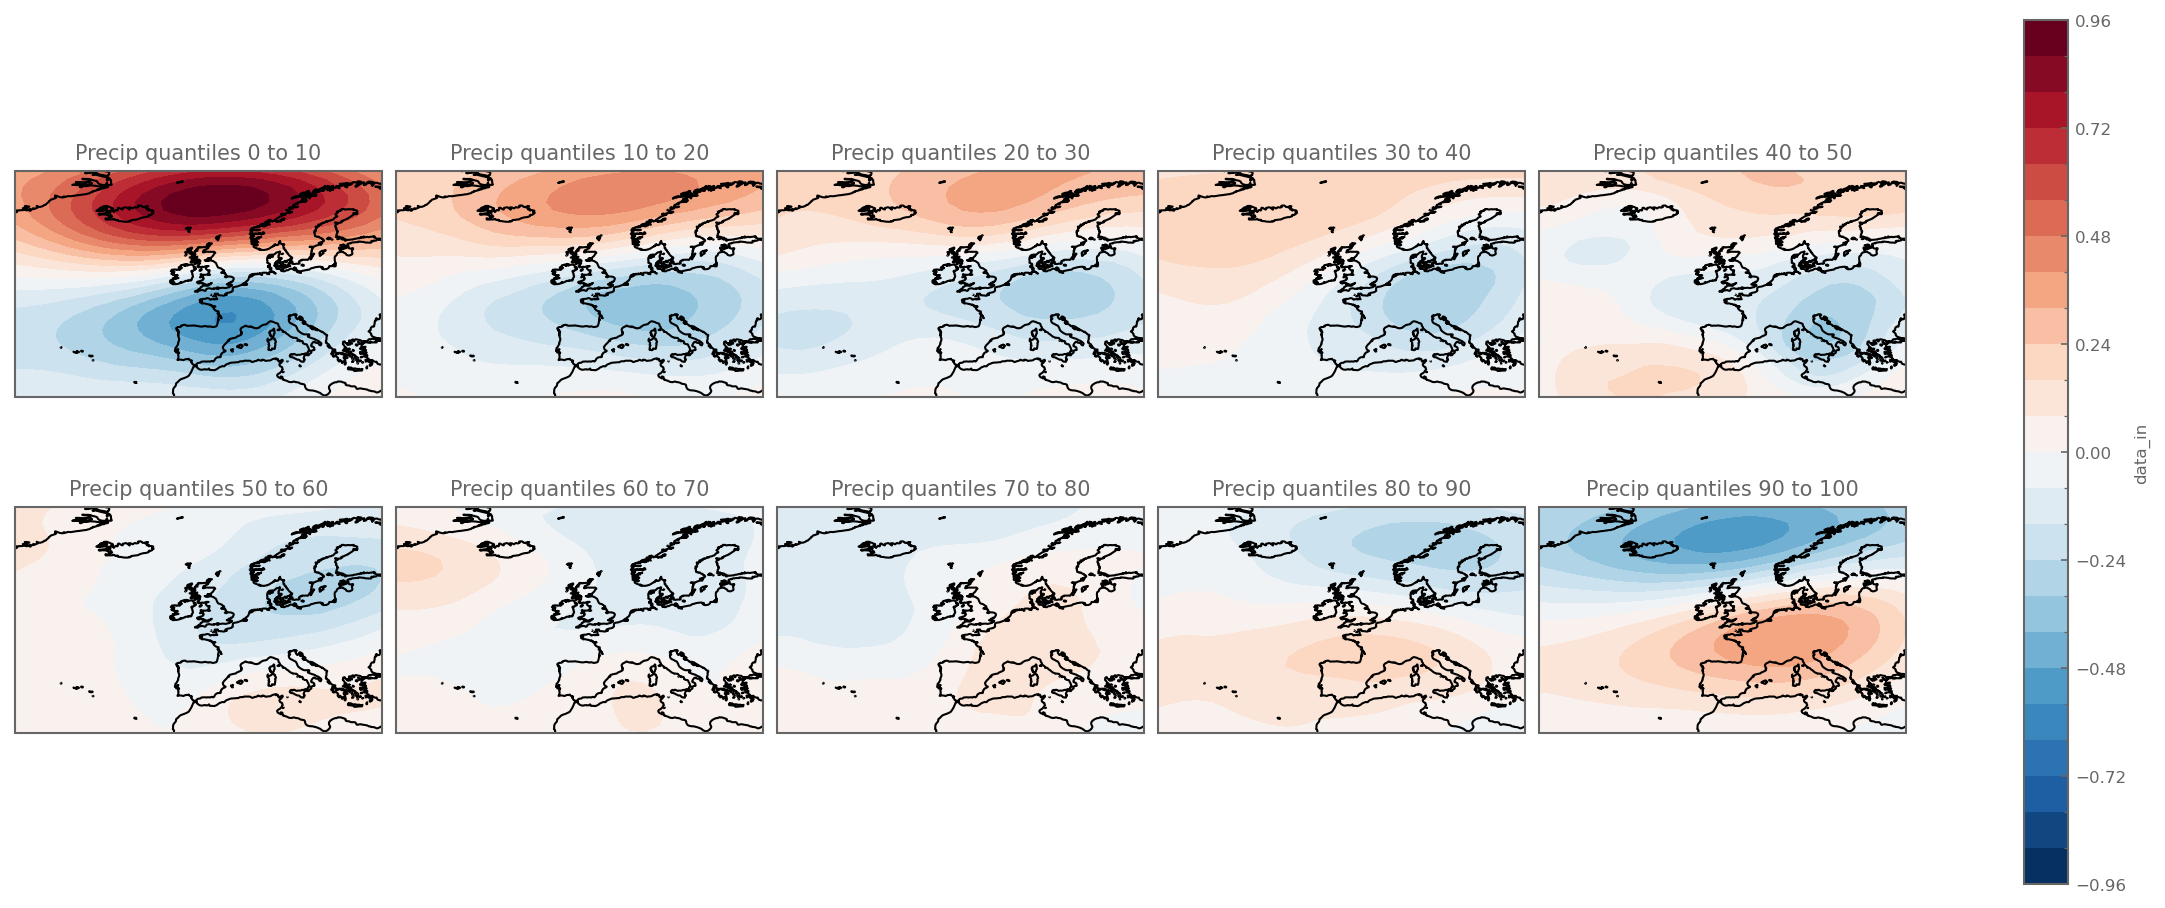

In [232]:
plot = (ds_mean_winter - ds_valid_winter.data_in.mean('time')).squeeze().plot.contourf(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                                                         col ='data_out', col_wrap=5,
                                                                         transform=ccrs.PlateCarree(), levels=30)
for k,ax in enumerate(plot.axs.flatten()):
    if k<10:
        # mean_attrs = ds_mean_winter_attrs.isel(data_out=k).rolling(longitude=5, latitude=5, center=True).mean()
        # mean_attrs = mean_attrs.where(np.abs(mean_attrs)>0.1)
        # mean_attrs.plot.contourf(transform=ccrs.PlateCarree(),ax=ax, levels=10, vmax=.4, vmin=-.4, add_colorbar=False, cmap='RdBu_r')
        ax.coastlines()
        ax.set_extent((-40,30, 30,70))
        ax.set_title(f"Precip quantiles {k*10} to {(k+1)*10}")

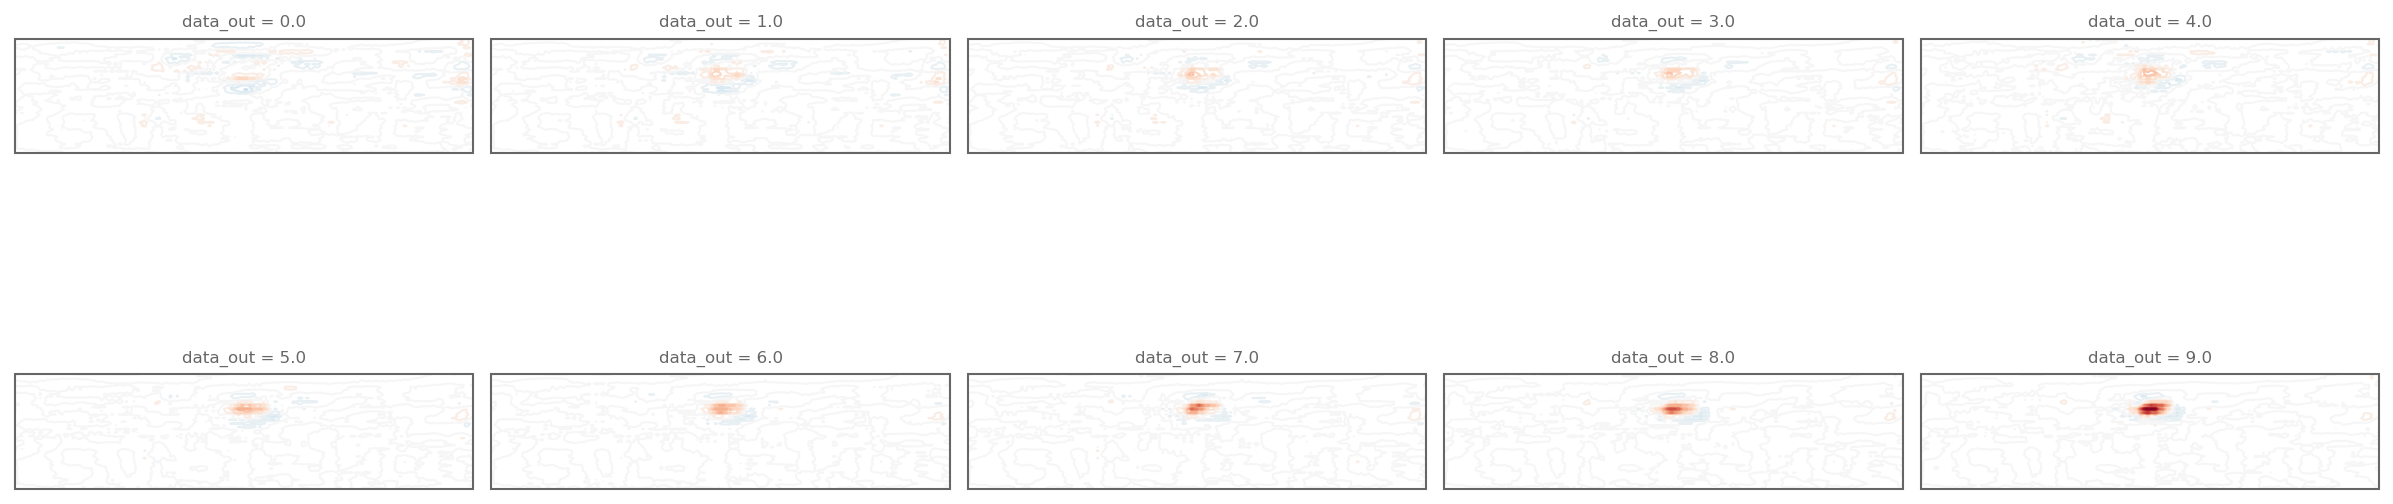

In [130]:
plot = ds_mean_winter_attrs.plot.contour(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                                                         col ='data_out', col_wrap=5,
                                                                         transform=ccrs.PlateCarree(), levels=30)

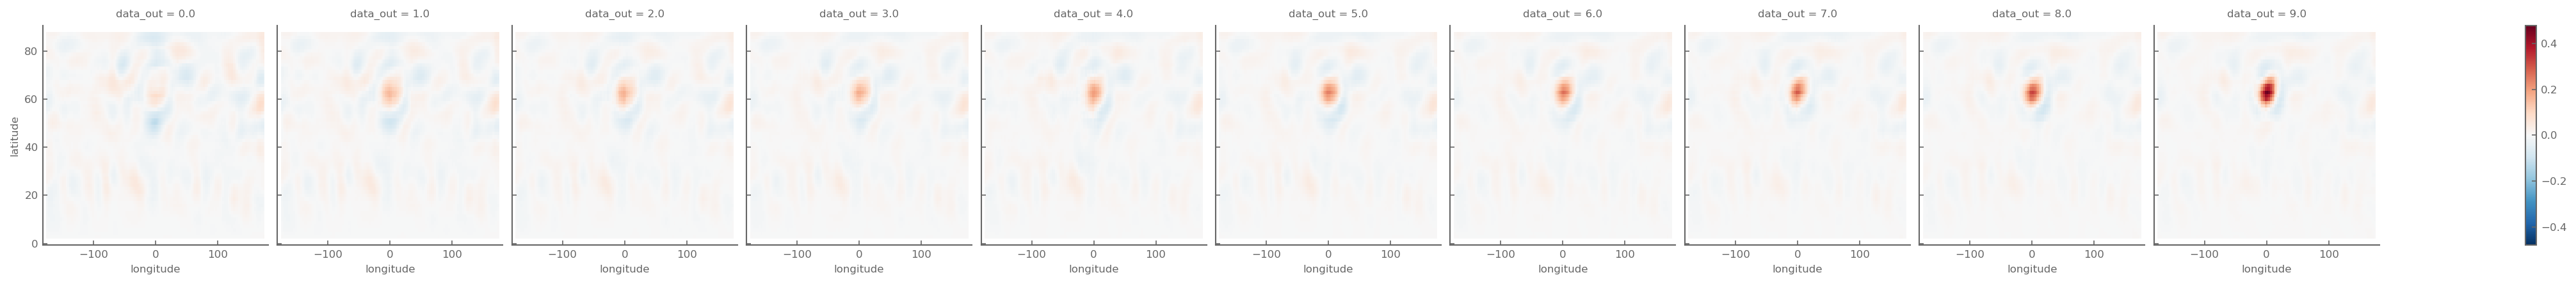

In [113]:
ds_mean_winter_attrs.rolling(longitude=5, latitude=5, center=True).mean().plot(col='data_out')

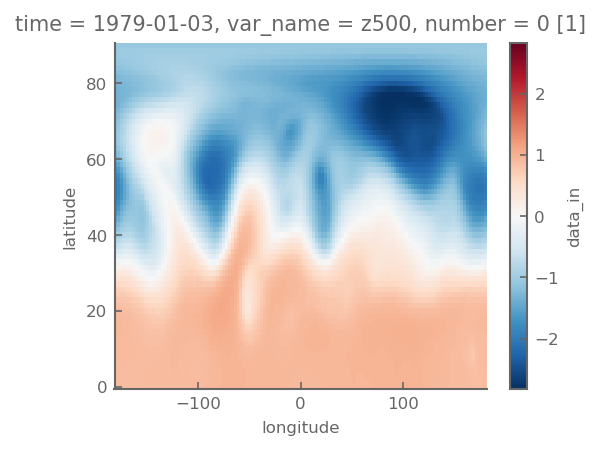

In [24]:
ds_attrs_quant.isel(time=0).plot()
plt.figure()
ds_valid.data_in.isel(time=0).plot()

In [11]:
all_quant = []
for quant in range(10):
    ds_quant_truth = ds_ml.sel(time = df_.query(f"pred=={quant}&truth=={quant}").index.get_level_values(0))
    input_tensor = torch.Tensor(ds_quant_truth.data_in.values).to('cpu')
    baseline = torch.zeros_like(input_tensor)

    all_attr = []
    for i in tqdm(range(input_tensor.shape[0])):
        attr_ig = ig.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
        all_attr.append(np.concatenate([attr_ig]))

    ds_attrs_quant = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
                dims=['method','time','var_name','latitude','longitude'], 
                coords= dict(time=ds_quant_truth.time,
                            longitude=ds_quant_truth.longitude, 
                            latitude=ds_quant_truth.latitude,
                            var_name=ds_quant_truth.var_name, 
                            #   method=['ig','nt','deeplift','occ']))
                            method=['nt']))
    ds_attrs_mean_quant = ds_attrs_quant.mean('time').assign_coords(q=quant*10)
    all_quant.append(ds_attrs_mean_quant)
    # print(ds_quant_truth.time.size)


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/1118 [00:00<?, ?it/s]

In [12]:
ds_attr = xr.concat(all_quant, dim='q')

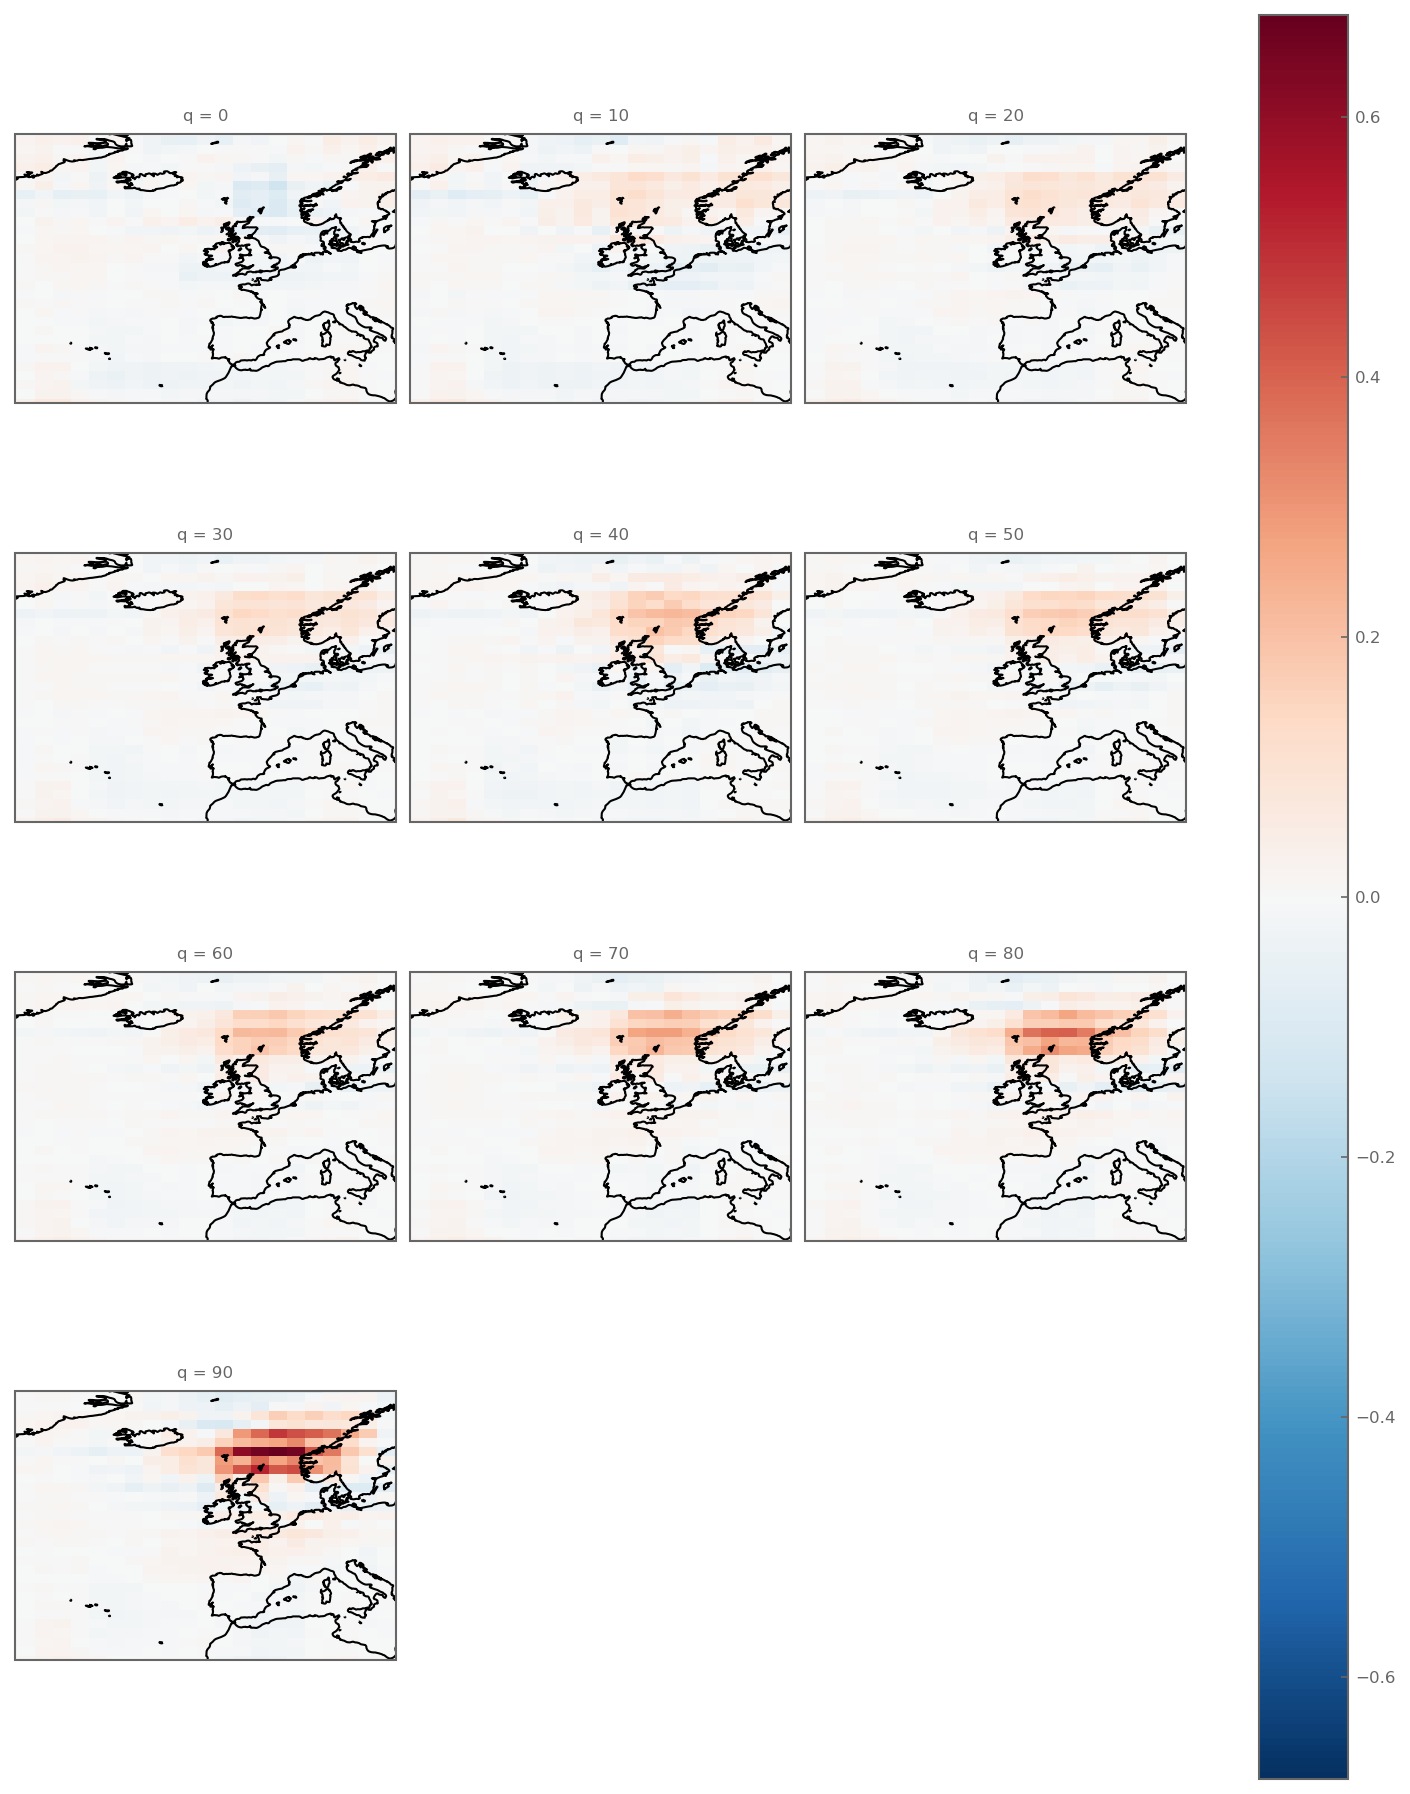

In [16]:
plot = ds_attr.squeeze().plot(subplot_kws = dict(projection=ccrs.PlateCarree()),
                               col ='q', col_wrap=3,
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))

In [ ]:
input_tensor = torch.Tensor(ds_over90.data_in.values).to('cpu')
baseline = torch.zeros_like(input_tensor)
target=9

all_attr = []
for i in tqdm(range(input_tensor.shape[0])):
    # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
    attr_ig = ig.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
    # attr_dl = dlShap.attribute(input_tensor[i:i+1], target=9).detach().numpy()
    # attr_occ = occ.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy()
    # all_attr.append(np.concatenate([attr_ig,attr_nt, attr_dl, attr_occ]))
    all_attr.append(np.concatenate([attr_ig]))


ds_attrs_above90 = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
             dims=['method','time','var_name','latitude','longitude'], 
             coords= dict(time=ds_over90.time,
                          longitude=ds_over90.longitude, 
                          latitude=ds_over90.latitude,
                          var_name=ds_over90.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                          method=['nt']))
ds_attrs_mean_above90 = ds_attrs_above90.mean('time')

# attrs_lrp = xr.DataArray(lrp.attribute(input_tensor, rule=).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_ig = xr.DataArray(np.concatenate(all_attr), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_nt = xr.DataArray(nt.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_occ = xr.DataArray(occ.attribute(input_tensor, baselines=baseline,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)
# attrs_dls = xr.DataArray(dlShap.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_over90.data_in.dims, coords=ds_over90.data_in.coords)


  0%|          | 0/1117 [00:00<?, ?it/s]

In [33]:
input_tensor = torch.Tensor(ds_below10.data_in.values).to('cpu')
baseline = torch.zeros_like(input_tensor)
target=9

all_attr = []
for i in tqdm(range(input_tensor.shape[0])):
    # attr_ig = ig_noinput.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9).detach().numpy()
    attr_ig = ig.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=0).detach().numpy()
    # attr_dl = dlShap.attribute(input_tensor[i:i+1], target=9).detach().numpy()
    # attr_occ = occ.attribute(input_tensor[i:i+1], baselines=baseline[i:i+1], target=9,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy()
    # all_attr.append(np.concatenate([attr_ig,attr_nt, attr_dl, attr_occ]))
    all_attr.append(np.concatenate([attr_ig]))


ds_attrs_below10 = xr.DataArray(np.array(all_attr).transpose(1,0,2,3,4), 
             dims=['method','time','var_name','latitude','longitude'], 
             coords= dict(time=ds_below10.time,
                          longitude=ds_below10.longitude, 
                          latitude=ds_below10.latitude,
                          var_name=ds_below10.var_name, 
                        #   method=['ig','nt','deeplift','occ']))
                          method=['nt']))
ds_attrs_mean_below10 = ds_attrs_below10.mean('time')

# attrs_lrp = xr.DataArray(lrp.attribute(input_tensor, rule=).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_ig = xr.DataArray(np.concatenate(all_attr), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_nt = xr.DataArray(nt.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_occ = xr.DataArray(occ.attribute(input_tensor, baselines=baseline,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)
# attrs_dls = xr.DataArray(dlShap.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_below10.data_in.dims, coords=ds_below10.data_in.coords)


  0%|          | 0/998 [00:00<?, ?it/s]

AttributeError: 'GeoQuadMesh' object has no attribute 'axs'

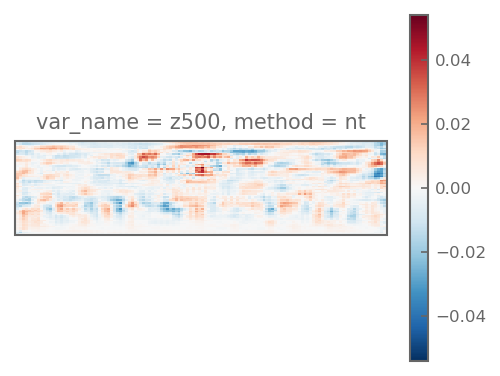

In [35]:
plot = ds_attrs_mean_below10.squeeze().plot(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))
    
plot = ds_attrs_mean_above90.squeeze().plot(subplot_kws = dict(projection=ccrs.PlateCarree()),
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))

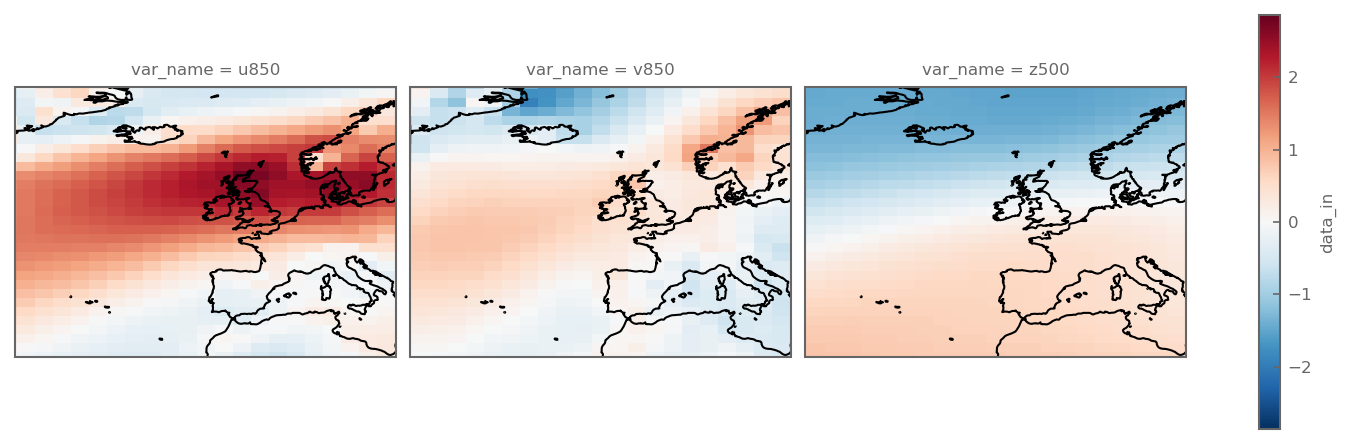

In [35]:

plot = ds_over90.data_in.mean('time').squeeze().plot(col='var_name', col_wrap=3, 
                                            subplot_kws = dict(projection=ccrs.PlateCarree()),
                                            transform=ccrs.PlateCarree())
for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-40,20, 30,70))

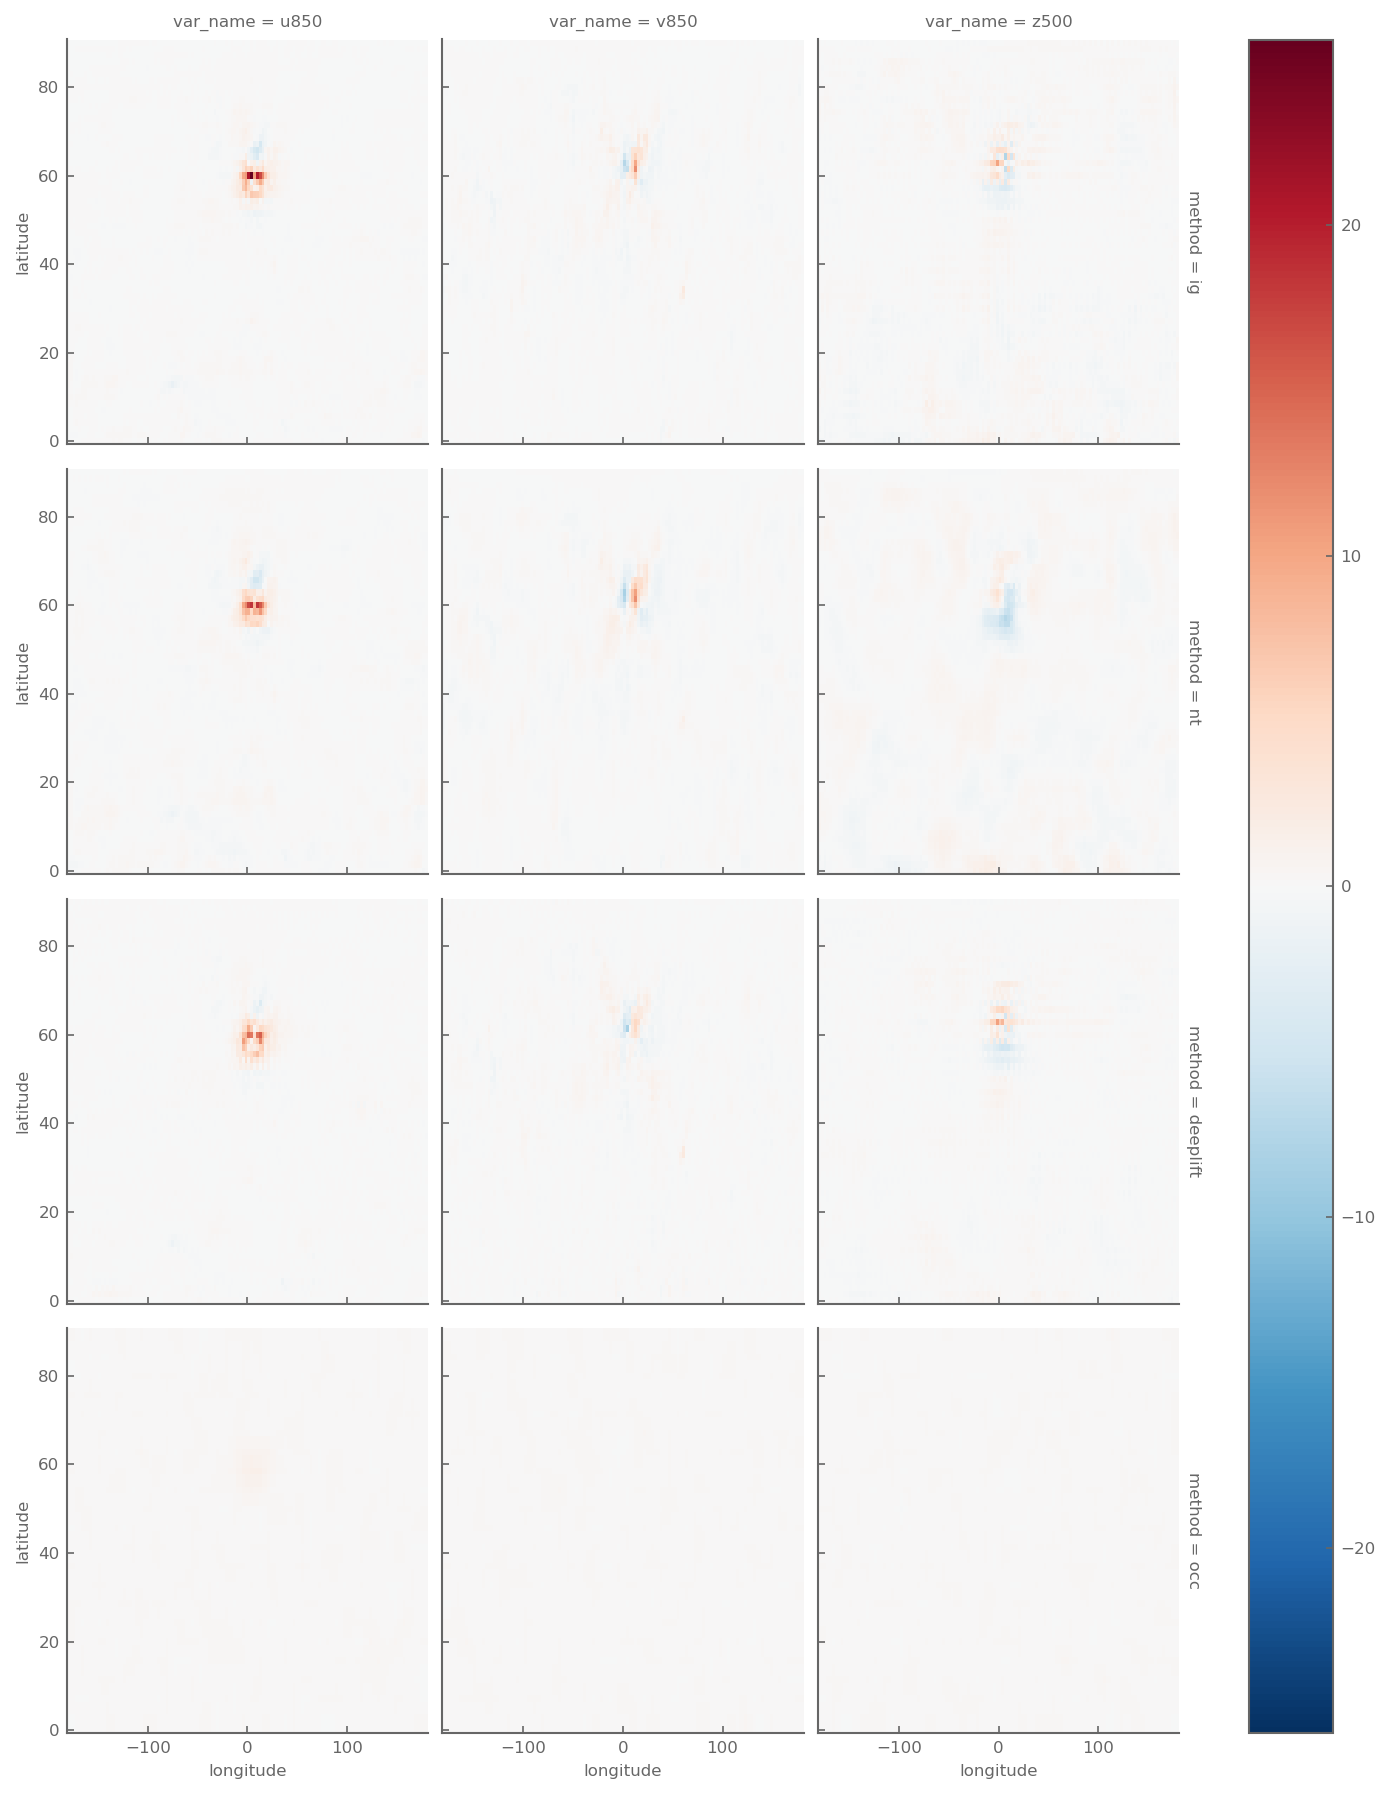

In [51]:
ds_attrs.mean('time').plot(col='var_name', row='method')

In [21]:
attrs_ig.mean('time').plot(col='var_name', robust=False)